# OOD Detection with LID: A Hands-on Guide

#### Written by: Hamid Kamkari (hamidrezakamkari@gmail.com)

Here, we will show you how to use our codebase to perform OOD detection. For simplicity, we consider OOD detection between fmnist and mnist here, but you can easily follow similar steps for other datasets, even for your own dataset. Before we start, we recommend you run the following script that downloads all the necessary resources that we will use in this noteboo such as model checkpoints that are already trained on mnist and fmnist datasets, alongside some reports that we will use to evaluate the performance of the models.

```bash
python scripts/download_resources.py
```

While we will heavily use the bash scripts that the codebase provides (make sure to run them while being at the repository root), we will use this notebook to take some of the artifacts produced by these scripts and visualize them. Therefore, make sure to follow the instructions to setup mlflow, and also run the following cell.

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from notebook_setup import device
torch.manual_seed(0)

## Running checkpoints

Here, we will work with diffusion and flow models that have been trained on mnist and fmnist datasets. Run the following bash commands to get 4 different mlflow logs for each model. If you have setup the repository correctly, this will produce an artifact file that contains a `<artifact_dir>/samples_grid/xxx.png` that contains relevant samples produces by these models.

```bash
# diffusion trained on fmnist
python scripts/train.py dataset=fmnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_fmnist
# diffusion trained on mnist
python scripts/train.py dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist
# flow trained on fmnist
python scripts/train.py dataset=fmnist +experiment=train_flow_greyscale +checkpoint=flow_fmnist
# flow trained on mnist
python scripts/train.py dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_mnist
```

## The likelihood paradox

We first reproduce the likelihood OOD paradox, whereby the likelihood of OOD data, even though unseen during training, will be larger than that of in-distribution data. To do so, we can use the following commands to reproduce this for both flows and diffusions.


```bash
# fmnist vs. mnist on flows
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_fmnist +ood=flow_likelihood_paradox
# mnist vs. fmnist on flows
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +ood=flow_likelihood_paradox
# fmnist vs. mnist on diffusions
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_fmnist +ood=diffusion_likelihood_paradox
# mnist vs. fmnist on diffusions
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist +ood=diffusion_likelihood_paradox
```

You may also add the extra options `ood_subsample_size=<x>` and `ood_batch_size=<x>` to control the number of samples used for OOD detection. The default values here are `4096` and `128`, respectively. This is because the OOD detection for diffusions in particular can be computationally expensive, and we might need to subsample the OOD data to make it feasible.

Note that we use the `train.py` script rather than a dedicated script for OOD detection. This is because the OOD detection is a simple extension of the training script, even when a checkpoint is unavailable, you can run the same script and it will train a model on the in-distribution data for the purpose of OOD detection. However, the most important reason of having it as an extension of `train.py` is that OOD detection using likelihoods, or as we will see, with LID, can be seen as monitoring different metrics of datapoints during training. Therefore, we implement it as a callback that can be used during training. We can then compose multiple callbacks to monitor different metrics, such as the likelihood of the data, the LID of the data, etc. 


Before moving on, let us visualize the likelihoods that we obtain. Every script will create an mlflow experiment with an appropriate mlflow artifacts directory. The artifacts should lie in `outputs/mlruns/??/??/artifacts/` and you can visualize them using the mlflow console as well. When moving to the logs of each of these runs, you will notice the following directories:

1. `samples_grid/xxx.png`: contains samples produced by the generative model and serves as a sanity check.
2. `likelihood_in_distr_train/`: This contains the monitoring results of the in-distribution data from the training set. 
3. `likelihood_in_distr_test/`: This contains the monitoring results of the in-distribution data from the test set.
4. `likelihood_ood/`: This contains the monitoring results of the OOD data.
5. `likelihood_generated/`: This contains the monitoring results of the generated data.

Each of these directories contains a `metrics=xxx.csv` file with a column labelled as `LikelihoodMetric` that contains the likelihoods of the data. We can use these likelihoods to visualize the likelihood paradox. Moreover, there is a `samples/idx.png` for `idx` ranging over the number of samples that we have used for monitoring. We can use these samples to visualize and have access to the samples that have been used for monitoring. 

Next, we store the artifact directory in our `.env` folder:

```bash
dotenv set OOD_LIKELIHOOD_PARADOX_FLOW_FMNIST <corresponding_artifact_dir>
dotenv set OOD_LIKELIHOOD_PARADOX_FLOW_MNIST <corresponding_artifact_dir>
dotenv set OOD_LIKELIHOOD_PARADOX_DIFFUSION_FMNIST <corresponding_artifact_dir>
dotenv set OOD_LIKELIHOOD_PARADOX_DIFFUSION_MNIST <corresponding_artifact_dir>
```

Note that if you have used our `download_resources.py` script, the results should be stored in the `.env` file already with some artifact directories that we have already used. Therefore, you can skip the step of generating these artifacts if the script takes too long to run on your machine. In fact, this pattern will be repeated for the rest of the notebook, where we introduce the set of commands to generate artifacts, and we also store our own runs already in the `.env` file if you have used the `download_resources.py` script.

Now, use the following cell to visualize the content in these tables. It will visualize 4 different plots showing the histogram of likelihoods for OOD samples, in-distribution (test and train split), and also, the generated samples (in gold). We see the peculiar behaviour on the generated samples' likelihoods as well which is always smaller than the in-distribution samples.

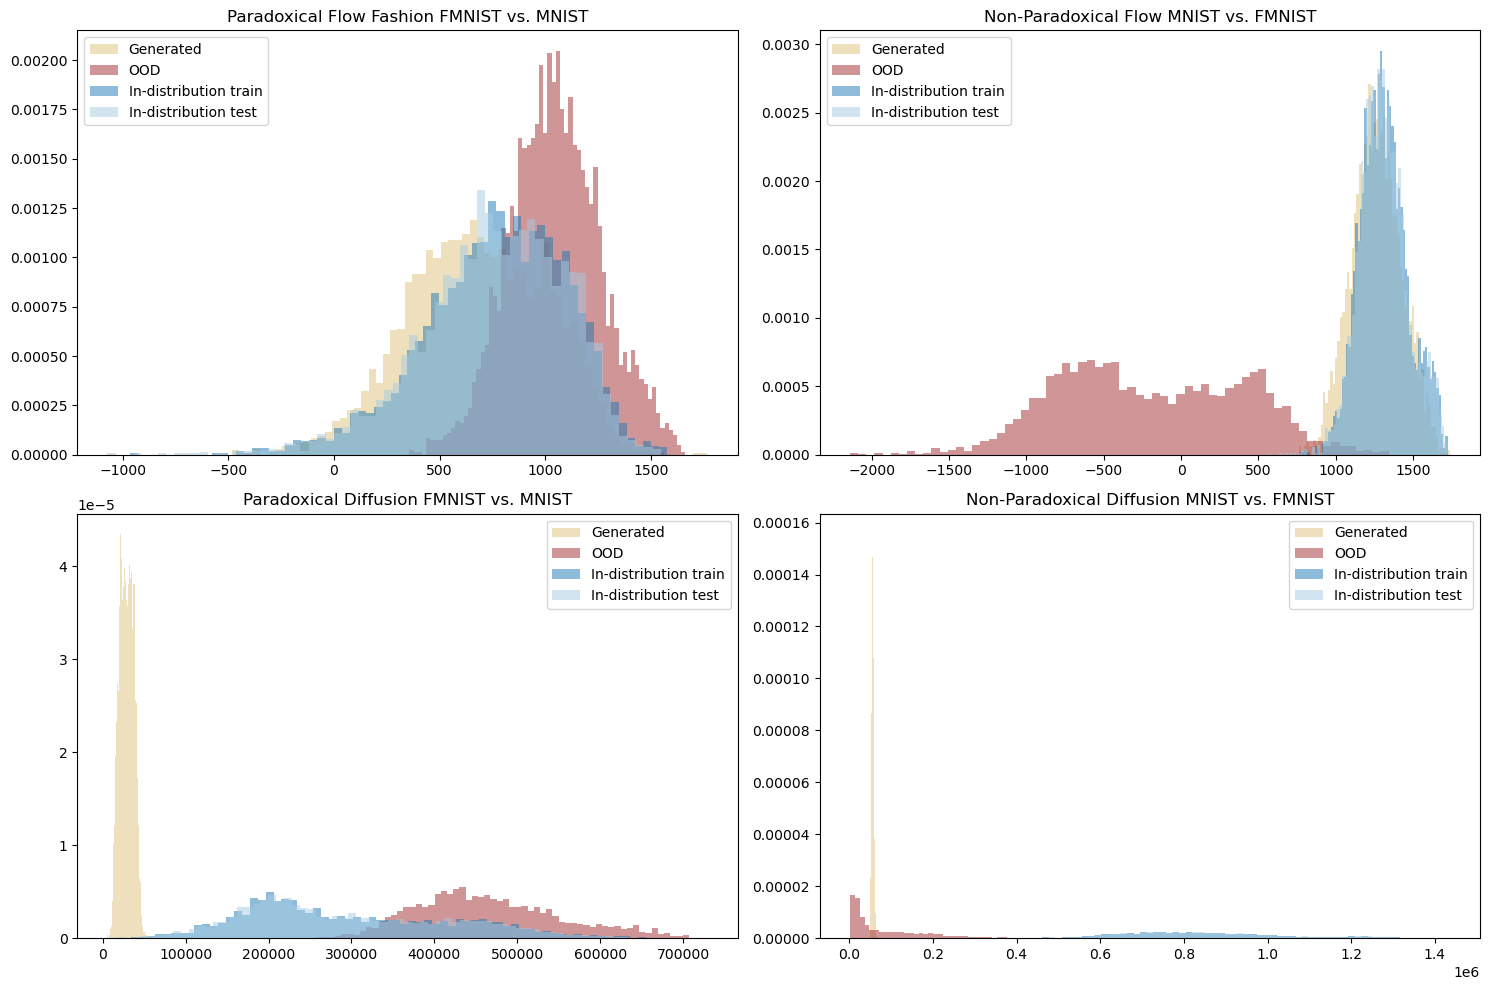

In [20]:
%autoreload 2
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
from visualization.pretty import ColorTheme
# load the environment variables
dotenv.load_dotenv(override=True)
import os

def visualize_likelihood_ood(ax, artifact_dir: str, title: str, bins: int = 100):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    likelihood_dir = os.path.join(artifact_dir, "likelihood_generated")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_generated = pd.read_csv(metrics_dir)['LikelihoodMetric']

    likelihood_dir = os.path.join(artifact_dir, "likelihood_ood")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_ood = pd.read_csv(metrics_dir)['LikelihoodMetric']
    
    likelihood_dir = os.path.join(artifact_dir, "likelihood_in_distr_train")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_in_distr_train = pd.read_csv(os.path.join(artifact_dir, metrics_dir))['LikelihoodMetric']
    
    likelihood_dir = os.path.join(artifact_dir, "likelihood_in_distr_test")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_in_distr_test = pd.read_csv(os.path.join(artifact_dir, metrics_dir))['LikelihoodMetric']

    # plot an overlapping histogram
    ax.hist(likelihood_generated, bins=bins, alpha=0.5, label="Generated", density=True, color=ColorTheme.GOLD.value)
    ax.hist(likelihood_ood, bins=bins, alpha=0.5, label="OOD", density=True, color=ColorTheme.RED_FIRST.value)
    ax.hist(likelihood_in_distr_train, bins=bins, alpha=0.5, label="In-distribution train", density=True, color=ColorTheme.BLUE_FIRST.value)
    ax.hist(likelihood_in_distr_test, bins=bins, alpha=0.5, label="In-distribution test", density=True, color=ColorTheme.BLUE_SECOND.value)
    ax.set_title(title)
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

visualize_likelihood_ood(
    ax=axs[0, 0],
    artifact_dir=os.getenv("OOD_LIKELIHOOD_PARADOX_FLOW_FMNIST"),
    title="Paradoxical Flow Fashion FMNIST vs. MNIST",
    bins=66,
)
visualize_likelihood_ood(
    ax=axs[0, 1],
    artifact_dir=os.getenv("OOD_LIKELIHOOD_PARADOX_FLOW_MNIST"),
    title="Non-Paradoxical Flow MNIST vs. FMNIST",
    bins=66,
)
visualize_likelihood_ood(
    ax=axs[1, 0],
    artifact_dir=os.getenv("OOD_LIKELIHOOD_PARADOX_DIFFUSION_FMNIST"),
    title="Paradoxical Diffusion FMNIST vs. MNIST",
    bins=66,
)
visualize_likelihood_ood(
    ax=axs[1, 1],
    artifact_dir=os.getenv("OOD_LIKELIHOOD_PARADOX_DIFFUSION_MNIST"),
    title="Non-Paradoxical Diffusion MNIST vs. FMNIST",
    bins=66,
)

plt.tight_layout()
plt.show()

## Monitoring LID on both In- and Out-of-distribution Data

In the paper ["A Geometric Explanation of the Likelihood OOD Detection Paradox"](https://arxiv.org/abs/2403.18910), the hyperparameters related to the LID estimation are calibrated using the training data an an external model-free LID estimator. Some prior and follow-up work such as [LIDL](https://arxiv.org/abs/2206.14882) and [FLIPD](https://arxiv.org/abs/2406.03537) have shown that model-free estimators are not reliable for high-dimensional image data. Thus, instead of calibrating the hyperparamter $\tau$ using a model-free estimator, we pick a subset of in- and out-of-distribution datapoints and visualize an LID curve: a curve for each datapoint indicating their LID estimate for different levels of $\tau$. Through this, we illustrate how the LID of OOD datapoints when they have a higher likelihood estimate is lower than the LID of in-distribution datapoints in a holistic manner.


Similar to before, we use an appropriate callback to do so and this will log certain artifacts in mlflow. We have already included our results if you use the `download_resources.py` script. If you want to reproduce the results, you can use the following commands:

```bash
# fmnist vs. mnist on flows
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_fmnist +ood=flow_lid_curve
# mnist vs. fmnist on flows
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +ood=flow_lid_curve
# fmnist vs. mnist on diffusions
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_fmnist +ood=diffusion_lid_curve
# mnist vs. fmnist on diffusions
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist +ood=diffusion_lid_curve
```

Again, each run will create an artifact directory and you can store them in the `.env` file using the following commands:

```bash
dotenv set OOD_LID_CURVE_FLOW_FMNIST <corresponding_artifact_dir>
dotenv set OOD_LID_CURVE_FLOW_MNIST <corresponding_artifact_dir>
dotenv set OOD_LID_CURVE_DIFFUSION_FMNIST <corresponding_artifact_dir>
dotenv set OOD_LID_CURVE_DIFFUSION_MNIST <corresponding_artifact_dir>
```

Now, by looking at the artifact directories, we will notice that we will have the same structure as before:

1. `lid_curve_generated`: This contains the LID curve of the generated data.
2. `lid_curve_in_distr_train`: This contains the LID curve of the in-distribution data from the training set.
3. `lid_curve_in_distr_test`: This contains the LID curve of the in-distribution data from the test set.
4. `lid_curve_ood`: This contains the LID curve of the OOD data.

Each of these files will already contain the LID curve png file in `trends/trend_epoch=xxx.png`. We care about the raw data here, which is inside a csv file `trends/trend_epoch=xxx.csv`. 
Here, we will use the csv files of `lid_curve_in_distr_test` versus the `lid_curve_ood` for better illustration. The following code will visualize the LID curves for the in-distribution and OOD data.

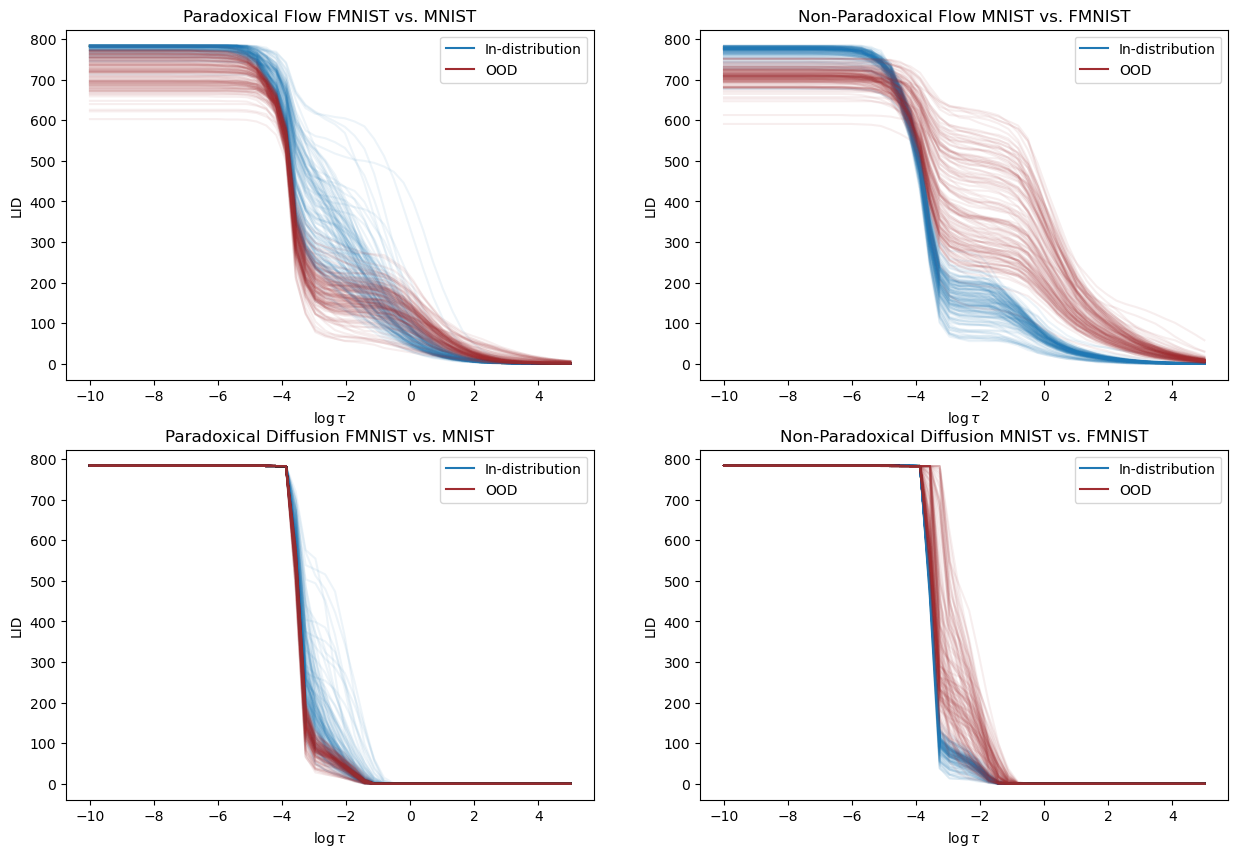

In [5]:
%autoreload 2
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import re
from visualization.pretty import ColorTheme
from visualization.trend import plot_trends
# load the environment variables
dotenv.load_dotenv(override=True)
import os

def visualize_lid_ood_curve(ax, artifact_dir: str, title: str, alpha=0.01, x_label="Sweeping argument", y_label="LID"):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    lid_curve_dir = os.path.join(artifact_dir, "lid_curve_in_distr_test", "trends")
    trend_files = [f for f in os.listdir(lid_curve_dir) if re.match(r'trend_epoch=\d+\.csv', f)][0]
    trend_in = pd.read_csv(os.path.join(lid_curve_dir, trend_files), index_col=0).values

    lid_curve_dir = os.path.join(artifact_dir, "lid_curve_ood", "trends")
    trend_files = [f for f in os.listdir(lid_curve_dir) if re.match(r'trend_epoch=\d+\.csv', f)][0]
    trend_ood = pd.read_csv(os.path.join(lid_curve_dir, trend_files), index_col=0).values

    sweeping_args_file = [f for f in os.listdir(lid_curve_dir) if f.startswith("sweeping_range")][0]
    sweeping_args_df = pd.read_csv(os.path.join(lid_curve_dir, sweeping_args_file), index_col=0)
    
    sweeping_arg = sweeping_args_df.columns[0]
    sweeping_values = sweeping_args_df[sweeping_arg].values
    for i in range(trend_in.shape[0]):
        ax.plot(sweeping_values, trend_in[i], color=ColorTheme.BLUE_FIRST.value, alpha=alpha)
    ax.plot([], [], color=ColorTheme.BLUE_FIRST.value, label="In-distribution")
    for i in range(trend_ood.shape[0]):
        ax.plot(sweeping_values, trend_ood[i], color=ColorTheme.RED_FIRST.value, alpha=alpha)
    ax.plot([], [], color=ColorTheme.RED_FIRST.value, label="OOD")
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

visualize_lid_ood_curve(
    ax=axs[0, 0],
    artifact_dir=os.getenv("OOD_LID_CURVE_FLOW_FMNIST"),
    title="Paradoxical Flow FMNIST vs. MNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_lid_ood_curve(
    ax=axs[0, 1],
    artifact_dir=os.getenv("OOD_LID_CURVE_FLOW_MNIST"),
    title="Non-Paradoxical Flow MNIST vs. FMNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_lid_ood_curve(
    ax=axs[1, 0],
    artifact_dir=os.getenv("OOD_LID_CURVE_DIFFUSION_FMNIST"),
    title="Paradoxical Diffusion FMNIST vs. MNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_lid_ood_curve(
    ax=axs[1, 1],
    artifact_dir=os.getenv("OOD_LID_CURVE_DIFFUSION_MNIST"),
    title="Non-Paradoxical Diffusion MNIST vs. FMNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
plt.show()



Looking at the above plots, it is clear that in the paradoxical scenarios (the left half) the LID of in-distribution data is larger than the out-of-distribution counterpart. In fact, for a very small $\tau$, even on the upper-right, we see that the LID of in-distribution data is larger than the out-of-distribution data which complies with the scatterplot results in (https://arxiv.org/abs/2403.18910). Now let us use the calibration procedure using an external model-free LID estimator. To get access to the calibration LID values, you can run some of our model-free LID estimator scripts. Note that if you run the same script without the alphaFO calibration, it will produce extremely unreasonable and small values, such as `8` for FMNIST. This is inline with (https://arxiv.org/abs/2406.03537) where shows that, without tuning, model-free LID estimators are not reliable for high-dimensional image data.

```bash
python scripts/model_free_lid.py dataset=fmnist lid_method=lpca +lid_method.estimator.alphaFO=0.001 +experiment=lid_greyscale # will produce ~ 222.48
python scripts/model_free_lid.py dataset=mnist lid_method=lpca +lid_method.estimator.alphaFO=0.001 +experiment=lid_greyscale # will produce ~ 251.62
```

Note that while these estimates are not reasonable on their own, they give us a baseline to calibrate $\tau$ with. The following piece of code does that logic and visualizes the $\tau$ values that produce the average LID that aligns most with these estimates. By looking at the dashed gold lines, it is easy to see that in the paradoxical scenarios, the $\tau$ value will produce LID estimates on the image above that can separate the in-distribution and out-of-distribution data. 


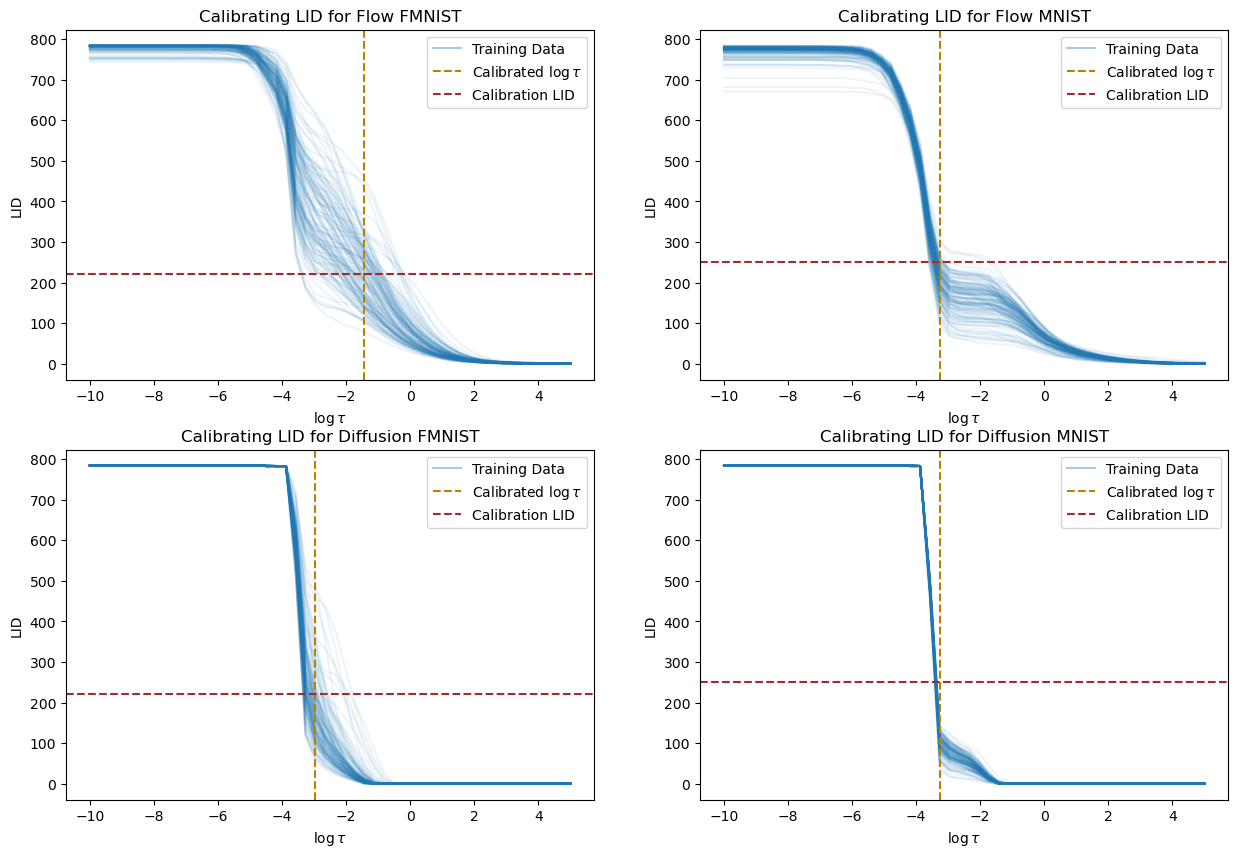

In [19]:
%autoreload 2
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import re
from visualization.pretty import ColorTheme
from visualization.trend import plot_trends
# load the environment variables
dotenv.load_dotenv(override=True)
import os

def visualize_calibration(
    ax, 
    artifact_dir: str, 
    title: str, 
    calibration_average_lid: float, 
    alpha=0.01, 
    x_label="Sweeping argument", 
    y_label="LID"
):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    lid_curve_dir = os.path.join(artifact_dir, "lid_curve_in_distr_train", "trends")
    trend_files = [f for f in os.listdir(lid_curve_dir) if re.match(r'trend_epoch=\d+\.csv', f)][0]
    trend_in = pd.read_csv(os.path.join(lid_curve_dir, trend_files), index_col=0).values

    sweeping_args_file = [f for f in os.listdir(lid_curve_dir) if f.startswith("sweeping_range")][0]
    sweeping_args_df = pd.read_csv(os.path.join(lid_curve_dir, sweeping_args_file), index_col=0)
    
    sweeping_arg = sweeping_args_df.columns[0]
    sweeping_values = sweeping_args_df[sweeping_arg].values

    best_log_tau = None
    best_avg = None
    for i, val in enumerate(sweeping_values):
        col = trend_in[:, i]
        avg = trend_in[:, i].mean()
        if best_log_tau is None or abs(avg - calibration_average_lid) < abs(best_avg - calibration_average_lid):
            best_log_tau = val
            best_avg = avg
        
    for i in range(trend_in.shape[0]):
        ax.plot(sweeping_values, trend_in[i], color=ColorTheme.BLUE_FIRST.value, alpha=alpha)
    ax.plot([], [], color=ColorTheme.BLUE_SECOND.value, label="Training Data")
    ax.axvline(x=best_log_tau, color=ColorTheme.PIRATE_GOLD.value, label="Calibrated $\\log \\tau$", linestyle="--")
    ax.axhline(y=calibration_average_lid, color=ColorTheme.RED_FIRST.value, label="Calibration LID", linestyle="--")
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

visualize_calibration(
    ax=axs[0, 0],
    artifact_dir=os.getenv("OOD_LID_CURVE_FLOW_FMNIST"),
    calibration_average_lid=222.48,
    title="Calibrating LID for Flow FMNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_calibration(
    ax=axs[0, 1],
    artifact_dir=os.getenv("OOD_LID_CURVE_FLOW_MNIST"),
    calibration_average_lid=251.62,
    title="Calibrating LID for Flow MNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_calibration(
    ax=axs[1, 0],
    artifact_dir=os.getenv("OOD_LID_CURVE_DIFFUSION_FMNIST"),
    calibration_average_lid=222.48,
    title="Calibrating LID for Diffusion FMNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
visualize_calibration(
    ax=axs[1, 1],
    artifact_dir=os.getenv("OOD_LID_CURVE_DIFFUSION_MNIST"),
    calibration_average_lid=251.62,
    title="Calibrating LID for Diffusion MNIST",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
plt.show()



While the calibration step is necessary to get reasonable estimate, we note that it is rather arbitrary. In fact, we only need a $\tau$ value that produces reasonable enough LID estimates for OOD detection. Therefore, in the following we just fix $\tau$ such that $\log \tau = -3$, as it seems to be a reasonable $\tau$ value by looking at the traning data LID curves, this is where "interesting" things happen in the LID curve.

## Scatterplot of LID and Likelihood

By fixing the threshold value, we can now run the following command to jointly logging the likelihood and LID values of the in-distribution and OOD data. 

```bash
# fmnist vs. mnist on flows
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_fmnist +ood=flow_lid_likelihood +lid_metric.singular_value_threshold=-3
# mnist vs. fmnist on flows
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +ood=flow_lid_likelihood +lid_metric.singular_value_threshold=-3
# fmnist vs. mnist on diffusions
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_fmnist +ood=diffusion_lid_likelihood +lid_metric.singular_value_threshold=-3
# mnist vs. fmnist on diffusions
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist +ood=diffusion_lid_likelihood +lid_metric.singular_value_threshold=-3

```

Again, each run will create an artifact directory and you can store them in the `.env` file using the following commands:

```bash
dotenv set OOD_LID_LIKELIHOOD_FLOW_FMNIST_1 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_FLOW_MNIST_1 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_DIFFUSION_FMNIST_1 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_DIFFUSION_MNIST_1 <corresponding_artifact_dir>
```

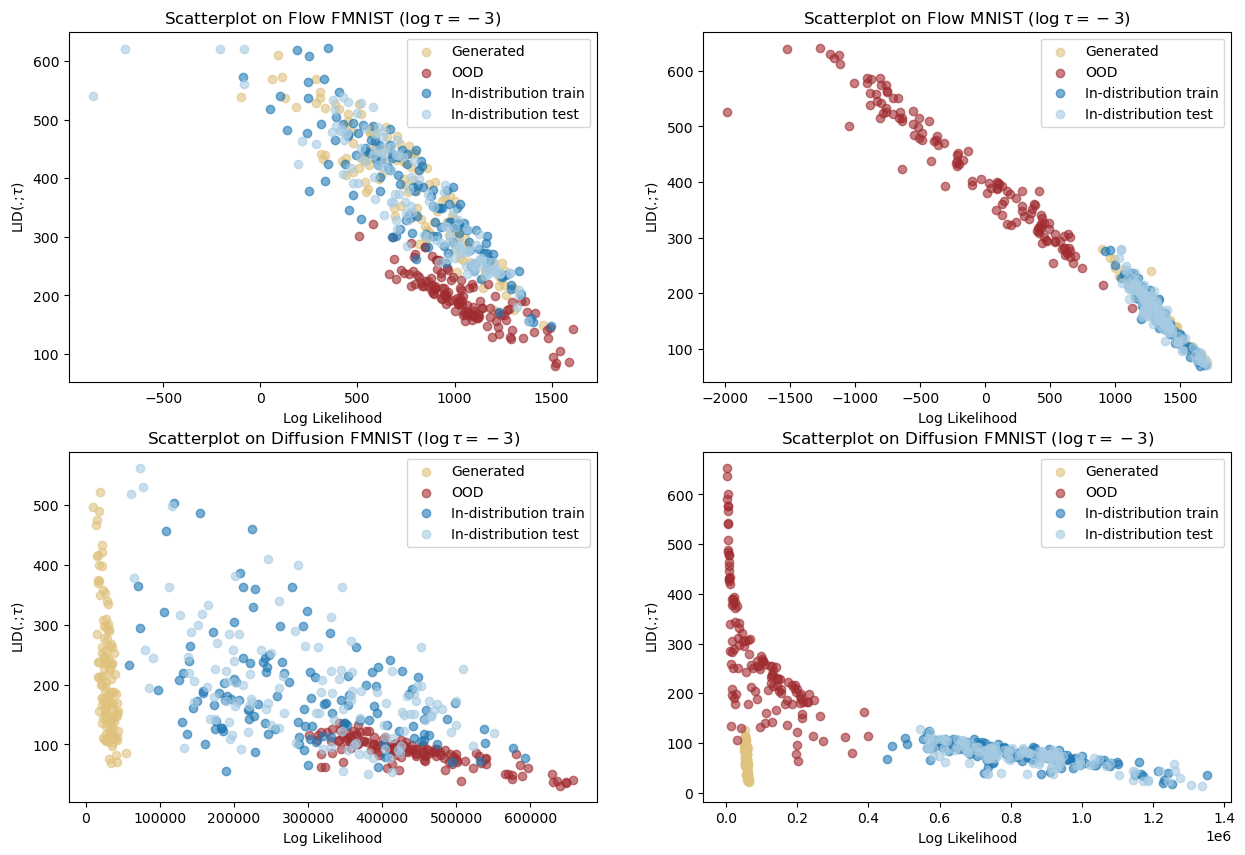

In [74]:
%autoreload 2
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import re
from visualization.pretty import ColorTheme
from visualization.trend import plot_trends
# load the environment variables
dotenv.load_dotenv(override=True)
import os

def visualize_scatterplot(
    ax, 
    artifact_dir: str, 
    title: str, 
    alpha=0.01, 
):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    likelihood_dir = os.path.join(artifact_dir, "lid_likelihood_generated")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_generated = pd.read_csv(metrics_dir)['likelihood']
    lid_generated = pd.read_csv(metrics_dir)['JacobianThresholdLID']

    likelihood_dir = os.path.join(artifact_dir, "lid_likelihood_ood")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_ood = pd.read_csv(metrics_dir)['likelihood']
    lid_ood = pd.read_csv(metrics_dir)['JacobianThresholdLID']
    
    likelihood_dir = os.path.join(artifact_dir, "lid_likelihood_in_distr_train")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_in_distr_train = pd.read_csv(metrics_dir)['likelihood']
    lid_in_distr_train = pd.read_csv(metrics_dir)['JacobianThresholdLID']
    
    likelihood_dir = os.path.join(artifact_dir, "lid_likelihood_in_distr_test")
    metrics_dir = [f for f in os.listdir(likelihood_dir) if f.startswith("metrics")][0]
    metrics_dir = os.path.join(likelihood_dir, metrics_dir)
    likelihood_in_distr_test = pd.read_csv(metrics_dir)['likelihood']
    lid_in_distr_test = pd.read_csv(metrics_dir)['JacobianThresholdLID']

    # plot an overlapping histogram
    ax.scatter(likelihood_generated, lid_generated, alpha=alpha, label="Generated", color=ColorTheme.GOLD.value)
    ax.scatter(likelihood_ood, lid_ood, alpha=alpha, label="OOD", color=ColorTheme.RED_FIRST.value)
    ax.scatter(likelihood_in_distr_train, lid_in_distr_train, alpha=alpha, label="In-distribution train", color=ColorTheme.BLUE_FIRST.value)
    ax.scatter(likelihood_in_distr_test, lid_in_distr_test, alpha=alpha, label="In-distribution test", color=ColorTheme.BLUE_SECOND.value)
    ax.set_xlabel("Log Likelihood")
    ax.set_ylabel("LID(.;$\\tau$)")
    ax.set_title(title)
    ax.legend()
    return {
        "generated": (likelihood_generated, lid_generated),
        "ood": (likelihood_ood, lid_ood),
        "in_distr_train": (likelihood_in_distr_train, lid_in_distr_train),
        "in_distr_test": (likelihood_in_distr_test, lid_in_distr_test),
    }


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lid_likelihood_flow_fmnist_1 = visualize_scatterplot(
    ax=axs[0, 0],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_FLOW_FMNIST_1"),
    title="Scatterplot on Flow FMNIST ($\\log \\tau=-3$)",
    alpha=0.6,
)

lid_likelihood_flow_mnist_1 = visualize_scatterplot(
    ax=axs[0, 1],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_FLOW_MNIST_1"),
    title="Scatterplot on Flow MNIST ($\\log \\tau=-3$)",
    alpha=0.6,
)

lid_likelihood_diffusion_fmnist_1 = visualize_scatterplot(
    ax=axs[1, 0],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_DIFFUSION_FMNIST_1"),
    title="Scatterplot on Diffusion FMNIST ($\\log \\tau=-3$)",
    alpha=0.6,
)
lid_likelihood_diffusion_mnist_1 = visualize_scatterplot(
    ax=axs[1, 1],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_DIFFUSION_MNIST_1"),
    title="Scatterplot on Diffusion FMNIST ($\\log \\tau=-3$)",
    alpha=0.6,
)
plt.show()



We will also try out another $\tau$ value below to show the robustness of the method. 

```bash
# fmnist vs. mnist on flows
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_fmnist +ood=flow_lid_likelihood +lid_metric.singular_value_threshold=-5
# mnist vs. fmnist on flows
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +ood=flow_lid_likelihood +lid_metric.singular_value_threshold=-5
# fmnist vs. mnist on diffusions
python scripts/train.py dataset=fmnist +ood_dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_fmnist +ood=diffusion_lid_likelihood +lid_metric.singular_value_threshold=-5
# mnist vs. fmnist on diffusions
python scripts/train.py dataset=mnist +ood_dataset=fmnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist +ood=diffusion_lid_likelihood +lid_metric.singular_value_threshold=-5
# save the artifact directories
dotenv set OOD_LID_LIKELIHOOD_FLOW_FMNIST_2 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_FLOW_MNIST_2 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_DIFFUSION_FMNIST_2 <corresponding_artifact_dir>
dotenv set OOD_LID_LIKELIHOOD_DIFFUSION_MNIST_2 <corresponding_artifact_dir>
```

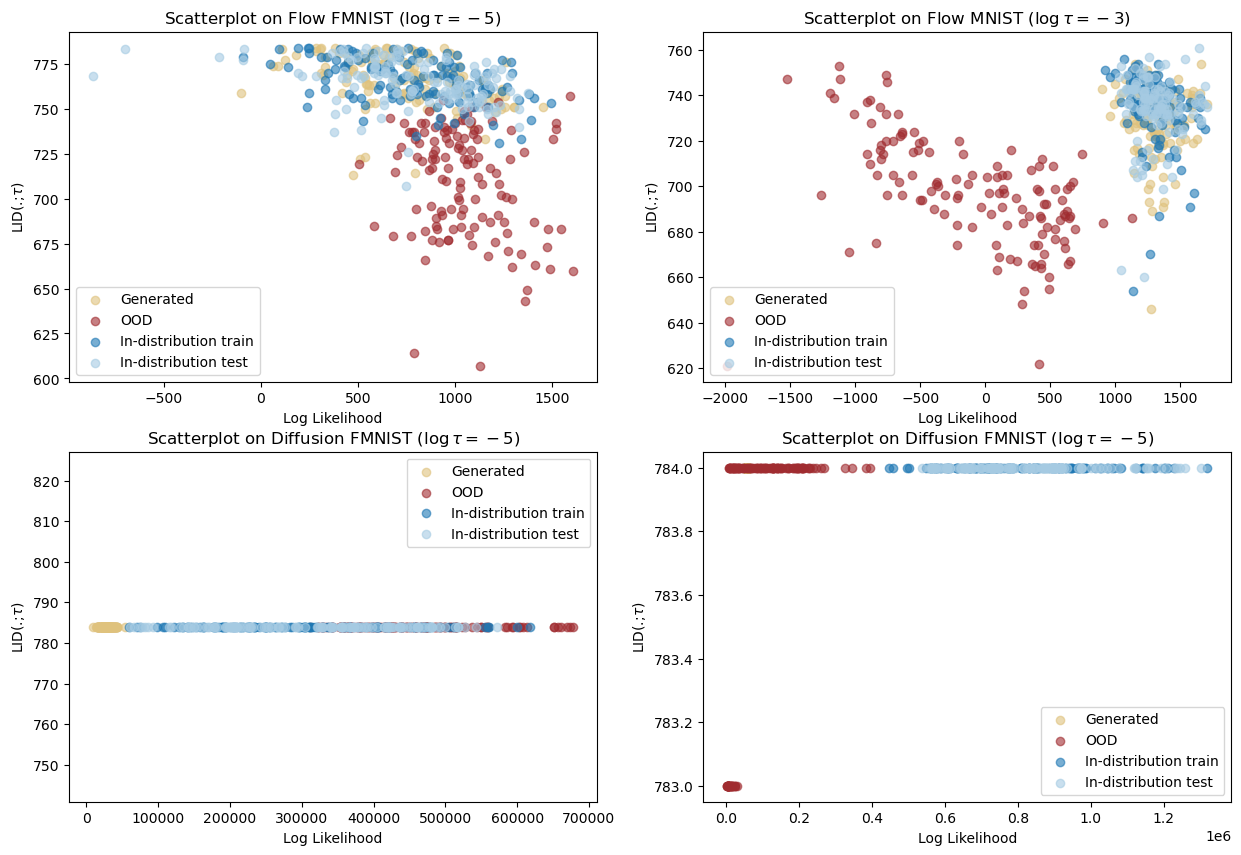

In [75]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lid_likelihood_flow_fmnist_2 = visualize_scatterplot(
    ax=axs[0, 0],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_FLOW_FMNIST_2"),
    title="Scatterplot on Flow FMNIST ($\\log \\tau=-5$)",
    alpha=0.6,
)

lid_likelihood_flow_mnist_2 = visualize_scatterplot(
    ax=axs[0, 1],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_FLOW_MNIST_2"),
    title="Scatterplot on Flow MNIST ($\\log \\tau=-3$)",
    alpha=0.6,
)

lid_likelihood_diffusion_fmnist_2 = visualize_scatterplot(
    ax=axs[1, 0],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_DIFFUSION_FMNIST_2"),
    title="Scatterplot on Diffusion FMNIST ($\\log \\tau=-5$)",
    alpha=0.6,
)
lid_likelihood_diffusion_mnist_2 = visualize_scatterplot(
    ax=axs[1, 1],
    artifact_dir=os.getenv("OOD_LID_LIKELIHOOD_DIFFUSION_MNIST_2"),
    title="Scatterplot on Diffusion FMNIST ($\\log \\tau=-5$)",
    alpha=0.6,
)
plt.show()

## Evaluating OOD Detection Results

We finally show how to evaluate the OOD detection results. To do so, we will use the dual threshold algorithm, where a datapoint is in-distribution if it has both high likelihood and high LID values, which translates to larger probability mass around the datapoint. We have recorded the LID and likelihood estimates of the above scatterplots. Run the following script to evaluate the results:

In [73]:
from metrics.ood.roc_analysis import get_roc_graph, get_pareto_frontier, get_auc


def print_aucs(results_dict):
    likelihood_generated, lid_generated = results_dict["generated"]
    likelihood_in_distr, lid_in_distr = results_dict["in_distr_test"]
    likelihood_ood, lid_ood = results_dict["ood"]

    roc_x, roc_y = get_roc_graph(
        pos_x=likelihood_in_distr,
        neg_x=likelihood_ood,
        verbose=0,
    )
    pareto_x, pareto_y = get_pareto_frontier(
        roc_x, roc_y,
    )
    print("[Single threshold] Test vs. OOD", get_auc(pareto_x, pareto_y))
    roc_x, roc_y = get_roc_graph(
        pos_x=likelihood_generated,
        neg_x=likelihood_ood,
        verbose=0,
    )
    pareto_x, pareto_y = get_pareto_frontier(
        roc_x, roc_y,
    )
    print("[Single threshold] Generated vs. OOD", get_auc(pareto_x, pareto_y))

    roc_x, roc_y = get_roc_graph(
        pos_x=likelihood_in_distr,
        pos_y=lid_in_distr,
        neg_x=likelihood_ood,
        neg_y=lid_ood,
        verbose=0,
    )
    pareto_x, pareto_y = get_pareto_frontier(
        roc_x, roc_y,
    )
    print("[Dual threshold] Test vs. OOD", get_auc(pareto_x, pareto_y))
    roc_x, roc_y = get_roc_graph(
        pos_x=likelihood_generated,
        pos_y=lid_generated,
        neg_x=likelihood_ood,
        neg_y=lid_ood,
        verbose=0,
    )
    pareto_x, pareto_y = get_pareto_frontier(
        roc_x, roc_y,
    )
    print("[Dual threshold] Generated vs. OOD", get_auc(pareto_x, pareto_y))

print("Normalizing flow [FMNIST vs. MNIST] (log tau = -3)")
print_aucs(lid_likelihood_flow_fmnist_1)
print("Normalizing flow [MNIST vs. FMNIST] (log tau = -3)")
print_aucs(lid_likelihood_flow_mnist_1)
print("Diffusion [FMNIST vs. MNIST] (log tau = -3)")
print_aucs(lid_likelihood_diffusion_fmnist_1)
print("Diffusion [MNIST vs. FMNIST] (log tau = -3)")
print_aucs(lid_likelihood_diffusion_mnist_1)
print("----")
print("Normalizing flow [FMNIST vs. MNIST] (log tau = -5)")
print_aucs(lid_likelihood_flow_fmnist_2)
print("Normalizing flow [MNIST vs. FMNIST] (log tau = -5)")
print_aucs(lid_likelihood_flow_mnist_2)
print("Diffusion [FMNIST vs. MNIST] (log tau = -5)")
print_aucs(lid_likelihood_diffusion_fmnist_2)
print("Diffusion [MNIST vs. FMNIST] (log tau = -5)")
print_aucs(lid_likelihood_diffusion_mnist_2)



Normalizing flow [FMNIST vs. MNIST] (log tau = -3)
[Single threshold] Test vs. OOD 0.2911376953125
[Single threshold] Generated vs. OOD 0.22869873046875
[Dual threshold] Test vs. OOD 0.94970703125
[Dual threshold] Generated vs. OOD 0.95135498046875
Normalizing flow [MNIST vs. FMNIST] (log tau = -3)
[Single threshold] Test vs. OOD 0.99920654296875
[Single threshold] Generated vs. OOD 0.999267578125
[Dual threshold] Test vs. OOD 0.99920654296875
[Dual threshold] Generated vs. OOD 0.999267578125
Diffusion [FMNIST vs. MNIST] (log tau = -3)
[Single threshold] Test vs. OOD 0.19720458984375
[Single threshold] Generated vs. OOD 0.0
[Dual threshold] Test vs. OOD 0.90802001953125
[Dual threshold] Generated vs. OOD 0.94866943359375
Diffusion [MNIST vs. FMNIST] (log tau = -3)
[Single threshold] Test vs. OOD 1.0
[Single threshold] Generated vs. OOD 0.4306640625
[Dual threshold] Test vs. OOD 1.0
[Dual threshold] Generated vs. OOD 0.4361572265625
----
Normalizing flow [FMNIST vs. MNIST] (log tau = -5

## Extending to Other Datasets

Throughout this notebook, we used FMNIST and MNIST as our illustrative datasets. However, you can easily extend this to other datasets by following the same steps above and would arrive at similar results, however, we note that in the case of FMNIST and MNIST these results are the most pronounced. You can use our dataset to train on other image datasets as well, and we support them through our HuggingFace integration, we have already included the CIFAR10 and SVHN datasets in our codebase. Finally, while most of these observations have been made on image datasets, we also support training diffusion models and normalizing flows for tabular datasets in our codebase. However, the likelihood paradox is not as pronounced in tabular datasets as it is in image datasets.


```bash
```